In [1]:
import numpy as np
import collections
import matplotlib.pyplot as plt

from scipy.special import logsumexp

import geometry
import itertools
from collections import defaultdict
import collections

from functools import reduce

from multiprocess import Pool
from functools import partial
import numpy as np
import geometry
import itertools 
from itertools import islice
import games
import geometry_v2
import cpb

import cpb_gaussian
import bpm
import random_algo
import plotly.graph_objects as go
import TSPM

import PM_DMED

#import ucbTSPM_v2
import cpb_gaussian_v2
import feedexp3_piccolboni

def evaluate_parallel(nbCores, n_folds, horizon, alg, game, type):
    print("nbCores:", nbCores, "nbFolds:", n_folds, "Horizon:", horizon)
    pool = Pool(processes = nbCores) 
    task = Evaluation(horizon, type)

    np.random.seed(1)
    distributions = []

    for jobid in range(n_folds):
        
        if type == 'easy' :
            p = np.random.uniform(0, 0.2) if np.random.uniform(0,1)>0.5 else np.random.uniform(0.8, 1)
        #elif type == 'easy' and jobid > 100:
        #    p = np.random.uniform(0.8, 1)
        else:
            p = np.random.uniform(0.4,0.6)
        distributions.append( [p, 1-p] )


    return np.asarray(  pool.map( partial( task.eval_policy_once, alg, game ), zip(distributions ,range(n_folds)) ) ) 


class Evaluation:

    def __init__(self, horizon,type ):
        self.type = type
        self.horizon = horizon
        # self.outcome_distribution = outcome_distribution

    

    def get_outcomes(self, game, job_id):
        # self.means = runif_in_simplex( self.game.n_outcomes )
        outcomes = np.random.choice( game.n_outcomes , p= list( game.outcome_dist.values() ), size= self.horizon) 
        return outcomes

    def get_feedback(self, game, action, outcome):
        return game.FeedbackMatrix[ action ][ outcome ]

    def eval_policy_once(self, alg, game, job):

        alg.reset()

        distribution, jobid = job

        np.random.seed(jobid)
        
        # outcome_distribution =  {'spam':0.05,'ham':0.95}

        outcome_distribution =  {'spam':distribution[0],'ham':distribution[1]}

        # p = get_easy() if game.mode == 'easy' else get_harsch() 
        # outcome_distribution =  {'a':p[0],'b':p[1],'c':p[2],'d':p[3],'e':p[4]}

        game.set_outcome_distribution( outcome_distribution )
        # print('optimal action', game.i_star)

        action_counter = np.zeros( (game.n_actions, self.horizon) )

        # generate outcomes obliviously
        outcomes = self.get_outcomes(game, jobid)

        for t in range(self.horizon):

            # policy chooses one action
            action = alg.get_action(t)

            # Environment chooses one outcome
            outcome = outcomes[t]

            #print('t', t, 'action', action, 'outcome', outcome, )

            feedback =  self.get_feedback( game, action, outcome )

            alg.update(action, feedback, outcome, None, t)
            
            # print('nu', alg.nu / alg.n )

            for i in range(game.n_actions):
                if i == action:
                    action_counter[i][t] = action_counter[i][t-1] +1
                else:

                    action_counter[i][t] = action_counter[i][t-1]

        regret = np.array( [ game.delta(i) for i in range(game.n_actions) ]).T @ action_counter

        return regret


In [2]:


n_cores = 1
n_folds = 1
horizon = 100

# np.seterr(all='raise')

# game = games.apple_tasting(False, outcome_distribution) 

game =  games.apple_tasting( False ) 

# print('optimal action', game.i_star)
alg = cpb.CPB(game, horizon, 1.01 )#PM_DMED.PM_DMED(  game, horizon,)
task = Evaluation(horizon, 'easy')

outcome_distribution = [0.2,0.8]
job = (outcome_distribution, 1 )

result = task.eval_policy_once(alg,game, job)
#plt.plot(range(horizon), result)
# fig = go.Figure( )
# regret = np.array([ game.delta(i) for i in range(game.n_actions) ]).T @ np.mean(result,0) 
# xcoords = np.arange(0,horizon,1).tolist()

# fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='blue'), mode='lines',  name='TPSM' )) # 


Restricted license - for non-production use only - expires 2023-10-25
weights [0. 1.]
t 0 action 0 outcome 1
t 1 action 1 outcome 1
pair [0, 1] tdelta [-1.] c 0.836707028992553 sign [-1.]
pair [1, 0] tdelta [1.] c 0.836707028992553 sign [1.]
P_t [0] N_t [] Nplus_t [] V_t [] R_t [] S [0] values {0: 0.0} action 0
t 2 action 0 outcome 0
pair [0, 1] tdelta [-1.] c 1.053374772602226 sign [-1.]
pair [1, 0] tdelta [1.] c 1.053374772602226 sign [1.]
P_t [0, 1] N_t [[0, 1], [1, 0]] Nplus_t [0 1] V_t [0 1] R_t [] S [0 1] values {0: 0.0, 1: 1.0} action 1
t 3 action 1 outcome 1
pair [0, 1] tdelta [-1.] c 0.836707028992553 sign [-1.]
pair [1, 0] tdelta [1.] c 0.836707028992553 sign [1.]
P_t [0] N_t [] Nplus_t [] V_t [] R_t [] S [0] values {0: 0.0} action 0
t 4 action 0 outcome 0
pair [0, 1] tdelta [-1.] c 0.9015354378942743 sign [-1.]
pair [1, 0] tdelta [1.] c 0.9015354378942743 sign [1.]
P_t [0] N_t [] Nplus_t [] V_t [] R_t [] S [0] values {0: 0.0} action 0
t 5 action 0 outcome 0
pair [0, 1] tdelt

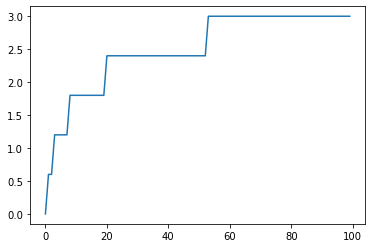

In [6]:
plt.plot(result)

In [3]:

import cpb_gaussian_v2
#import ucbTSPM_v2
n_cores = 8
n_folds = 100
horizon = 1000
# outcome_distribution =  {'spam':0.05,'ham':0.95}

game = games.apple_tasting(False)


#feedexp3.FeedExp3(  game, horizon, ),
#feedexp3_v3.FeedExp3(  game, horizon, ),
#eTSPM.eTSPM_alg(  game, horizon, 1),
#TSPM.TSPM_alg(  game, horizon,), bpm.BPM(  game, horizon,  [0.5, 0.5 ], np.identity(2) ) ,

#TSPM.TSPM_alg(  game, horizon,), 
#ucbTSPM_v2.TSPM_alg(game, horizon)  
algos = [   random_algo.Random(  game, horizon, ),

            feedexp3_piccolboni.FeedExp3(  game, horizon, ),

            cpb.CPB(  game, horizon, 1.01), 
            cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10), 

            PM_DMED.PM_DMED(  game, horizon,),   

            TSPM.TSPM_alg(  game, horizon, 1),
            TSPM.TSPM_alg(  game, horizon, 0), 

            bpm.BPM(game,horizon),  ] 


        #PM_DMED.PM_DMED(  game, horizon,),   
        #TSPM.TSPM_alg(  game, horizon, 1),   ] 

        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01, True), 
        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01, False), ]
        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01),
        #TSPM.TSPM_alg(game, horizon, 1 ) ]
        #TSPM.TSPM_alg(game, horizon, 0 )   #eTSPM.eTSPM_alg(game, horizon, 1), cpb_uniform.CPB_uniform(  game, horizon, 1.01), 

colors = [  [0,0,0], [250,0,0], [0,250,0], [0,125,0], [250,0,250], [0,0,250], [0,0,125],  [0,125,125]  ] #, [250,0,0], [200,0,0], [0,150,0], [0,250,0], [0,150,0], [0,0,250], [0,0,0],  [0,255,0], [0 , 150, 0], [155,155,0], [255,0,0], [0,0,255] , [255,51,255], [255,51,255], [255,20,200]  ] #
labels = [   'random', 'Piccolboni','CBP', 'RandCBP', 'PM_DMED', 'TSPM_R1', 'TSPM_R0', 'BPM_LEAST'   ]  #'random', 'RandCPB', 'random', 'TSPM' , 'TSPM (R=0)', 'RandCBP (uncoupled)','CPB uniform', ,'TSPM' , 'ucbTSPM (Auer)' 'FeedExp3 (2001)', 'FeedExp3 (2006)', 'CPB',  'eTSPM (Auer)',


fig = go.Figure(    )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'hard')
    regret =  np.mean(result,0) 
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    np.save('./results/apple_tasting/hard_{}_{}_{}'.format(horizon,n_folds, label), result)

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=False )

    )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 100] )

fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )
#fig.write_image("./hard_AT.pdf")

fig.show()

n-actions 2 n-outcomes 2 alphabet 2
n-actions 2 n-outcomes 2 alphabet 2
nbCores: 8 nbFolds: 100 Horizon: 1000
nbCores: 8 nbFolds: 100 Horizon: 1000
nbCores: 8 nbFolds: 100 Horizon: 1000
nbCores: 8 nbFolds: 100 Horizon: 1000
nbCores: 8 nbFolds: 100 Horizon: 1000


In [2]:



n_cores = 16
n_folds = 50
horizon = 1000
# outcome_distribution =  {'spam':0.05,'ham':0.95}

game = games.apple_tasting(False)

algos = [   random_algo.Random(  game, horizon, ),

            feedexp3_piccolboni.FeedExp3(  game, horizon, ),

            cpb.CPB(  game, horizon, 1.01), 
            cpb_gaussian.CPB_gaussian(  game, horizon, 1.01, True, 1/16, 10), 

            PM_DMED.PM_DMED(  game, horizon,),   

            TSPM.TSPM_alg(  game, horizon, 1),
            TSPM.TSPM_alg(  game, horizon, 0), 

            bpm.BPM(game,horizon),  ] 


        #PM_DMED.PM_DMED(  game, horizon,),   
        #TSPM.TSPM_alg(  game, horizon, 1),   ] 

        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01, True), 
        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01, False), ]
        #cpb_gaussian_v2.CPB_gaussian(  game, horizon, 1.01),
        #TSPM.TSPM_alg(game, horizon, 1 ) ]
        #TSPM.TSPM_alg(game, horizon, 0 )   #eTSPM.eTSPM_alg(game, horizon, 1), cpb_uniform.CPB_uniform(  game, horizon, 1.01), 

colors = [  [0,0,0], [250,0,0], [0,250,0], [0,125,0], [250,0,250], [0,0,250], [0,0,125],  [0,125,125]  ] #, [250,0,0], [200,0,0], [0,150,0], [0,250,0], [0,150,0], [0,0,250], [0,0,0],  [0,255,0], [0 , 150, 0], [155,155,0], [255,0,0], [0,0,255] , [255,51,255], [255,51,255], [255,20,200]  ] #
labels = [   'random', 'Piccolboni','CBP', 'RandCBP', 'PM_DMED', 'TSPM_R1', 'TSPM_R0', 'BPM_LEAST'   ]  #'random', 'RandCPB', 'random', 'TSPM' , 'TSPM (R=0)', 'RandCBP (uncoupled)','CPB uniform', ,'TSPM' , 'ucbTSPM (Auer)' 'FeedExp3 (2001)', 'FeedExp3 (2006)', 'CPB',  'eTSPM (Auer)',

fig = go.Figure(    )

for alg, color, label in zip( algos, colors, labels):

    r,g,b = color
    result = evaluate_parallel(n_cores, n_folds, horizon, alg, game, 'easy')
    regret =  np.mean(result,0) 
    
    xcoords = np.arange(0,horizon,1).tolist()
    std =  np.std(result,0) 
    upper_regret = regret + std

    np.save('./results/apple_tasting/easy_{}_{}_{}'.format(horizon,n_folds, label), result)

    fig.add_trace(go.Scatter(x=xcoords, y=regret, line=dict(color='rgb({},{},{})'.format(r,g,b)), mode='lines',  name=label )) # 

    fig.add_trace(   go.Scatter( x=xcoords+xcoords[::-1], y=upper_regret.tolist()+regret.tolist()[::-1],  fill='toself', fillcolor='rgba({},{},{},0.2)'.format(r,g,b), 
                         line=dict(color='rgba(255,255,255,0)'),   hoverinfo="skip",  showlegend=True )

    )
    
fig.show(legend=True)
fig.update_yaxes(range=[0, 20] )
fig.update_layout(legend= dict(yanchor="top",y=0.98,xanchor="left",x=0.77), autosize=False,
                 xaxis_title="Sequence",
                 yaxis_title="Regret",
                 margin=go.layout.Margin( l=0,   r=0,   b=0,    t=0, ), 
                  font=dict(size=13,) )
#fig.write_image("./easy_AT.pdf")

fig.show()

Restricted license - for non-production use only - expires 2023-10-25
weights [0. 1.]
n-actions 2 n-outcomes 2 alphabet 2
n-actions 2 n-outcomes 2 alphabet 2
n-actions 2 n-outcomes 2 alphabet 2
n-actions 2 n-outcomes 2 alphabet 2
nbCores: 16 nbFolds: 50 Horizon: 1000
nbCores: 16 nbFolds: 50 Horizon: 1000
nbCores: 16 nbFolds: 50 Horizon: 1000
nbCores: 16 nbFolds: 50 Horizon: 1000
nbCores: 16 nbFolds: 50 Horizon: 1000
nbCores: 16 nbFolds: 50 Horizon: 1000
nbCores: 16 nbFolds: 50 Horizon: 1000
nbCores: 16 nbFolds: 50 Horizon: 1000


In [4]:
a = [ np.array([1,2,3]), np.array([1,2,3,4,5])]
np.save('./test', a)

/home/mheuillet/anaconda3/envs/climate-ai/lib/python3.9/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.

